In [43]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [44]:
#mat["train"].shape 
#Relevant info about dimension of dataset (12, 18, 1114, 15)
#target (True label) [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
#channels, only use the first 8; channel 7 =OZ
#total samples
#trials (i.e. repeated experiments)

In [45]:
fs=256

In [46]:
#Load the data and cleans it, by cleaning I mean we are trucating the first 0.13s non-experiment time
#as well as removing a few samples to make later classification process easier
def load_data(filepath,target_index,channel,trial_num):
    mat = scipy.io.loadmat(filepath)
    data=mat['train'][target_index,channel,:,trial_num]
    sti=0.15
    
    vis_delay=0.13
    data_discard=math.floor((sti+vis_delay)*fs)
    data=data[data_discard:] #stimulus onset starts at 0.15s+visual delay 0.13s
    data=data[:1024]
    return data
#x=np.linspace(0,(1114-data_discard)/256,1114-data_discard)

#x=x[:1024] #make later classification simpler

In [47]:
#bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def clean_data(data,lowcut, highcut, fs, order=6):
    filtered_data = butter_bandpass_filter(data, lowcut, highcut, fs, order=6)
    return filtered_data

# Sample rate and desired cutoff frequencies (in Hz)
# #t = np.linspace(0, 1, fs, endpoint=False)
# # Apply bandpass filter
# filtered_data = butter_bandpass_filter(data, lowcut, highcut, fs, order=6)

# # Plot results
# plt.figure(figsize=(10, 6))
# #plt.plot(stream['time_stamps'][:250], data[:250], 'b-', label='Original Data')
# plt.plot(x[:250], filtered_data[:250], 'r-', linewidth=2, label='Filtered Data')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.title('Bandpass Filter Example')
# plt.legend()
# plt.grid(True)
# plt.show()

In [48]:
def compute_fft(data, fs):
    n = len(data)
    fft_data = np.fft.fft(data) / n
    freqs = np.fft.fftfreq(n, 1 / fs)
    return freqs[:n // 2], np.abs(fft_data)[:n // 2]

In [49]:
#offset in samples
#length of training data in seconds
#lowcut,highcut defines the cutoff range for bandpass filter in frequency(Hz)
def feature_train(data,length,offset,fs=256):
    all_feature=[]
    x=int((len(data)-fs*length)/offset)
    for i in range(x+1):
    #for i in range(5):
        start=i*offset
        end=length*fs+i*offset
        data_chunk=data[start:end]
        freqs_filtered, fft_filtered=compute_fft(data_chunk, fs)
        lower_bound=np.where(freqs_filtered==8)[0][0]
        higher_bound=np.where(freqs_filtered==16)[0][0]+1
        feature=fft_filtered[lower_bound:higher_bound]
        feature_norm=feature/max(feature)
        all_feature.append(feature_norm)
    return all_feature

In [50]:
# length=1 #2 seconds
# offset=16 #16 samples
# all_features=feature_train(data,length,offset,fs)


# Compute FFT of original data
#freqs_original, fft_original = compute_fft(data, fs)

# Compute FFT of filtered data
# freqs_filtered, fft_filtered = compute_fft(filtered_data, fs)
# #print(freqs_filtered)
# freqs_filtered=freqs_filtered[10:60]
# fft_filtered=fft_filtered[10:60]
# index_max = np.argmax(fft_filtered)
# print(freqs_filtered[index_max])
# # Plot FFT results
# plt.figure(figsize=(12, 6))
# # plt.subplot(2, 1, 1)
# # plt.plot(freqs_original, fft_original, label='Original Data')
# # plt.title('FFT of Original Data')
# # plt.xlabel('Frequency (Hz)')
# # plt.ylabel('Amplitude')
# # plt.grid(True)
# # plt.legend()

# plt.subplot(2, 1, 1)
# plt.plot(freqs_filtered, fft_filtered, color='red', label='Filtered Data')
# plt.title('FFT of Filtered Data')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xticks(range(1,31))
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()

In [51]:
filepath_list = [
    "s1.mat",
    "s2.mat",
    "s3.mat",
    "s4.mat",
    "s5.mat",
    "s6.mat",
    "s7.mat",
    "s8.mat",
    "s9.mat",
    "s10.mat"
]


In [52]:
#filepath="Masaki_SSVEP/s4.mat"
target=[9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
#target_index=0
channel=6 #OZ
fs = 256 # Sample rate
lowcut = 8  # Lower cutoff frequency
highcut = 16  # Higher cutoff frequency
length=3 #1 second
offset=16 #16 samples
# extract features for all trials with the same target index
'''
def extract_feature_all_trial(filepath,target_index):
    features_all_trial=[]
    for trial in range(10):
        data=load_data(filepath,target_index,channel,trial)
        data=clean_data(data,lowcut, highcut, fs, order=6)
        all_features=feature_train(data,length,offset,fs)
        features_all_trial.append(all_features)
    features_all_trial_trainX = np.concatenate([row for row in features_all_trial]) #convert into 2-D array
    features_all_trial_trainY = np.full(features_all_trial_trainX.shape[0], target[target_index])
    return features_all_trial_trainX, features_all_trial_trainY
'''
def extract_feature_all_trial(filepath_list, target_index):
    features_all_trial = []
    for filepath in filepath_list:
        for trial in range(15):
            data = load_data(filepath, target_index, channel, trial)
            data = clean_data(data, lowcut, highcut, fs, order=6)
            all_features = feature_train(data, length, offset, fs)
            features_all_trial.append(all_features)
    features_all_trial_trainX = np.concatenate([row for row in features_all_trial])  # Convert into 2-D array
    features_all_trial_trainY = np.full(features_all_trial_trainX.shape[0], target[target_index])
    return features_all_trial_trainX, features_all_trial_trainY


In [53]:
def concat_feature(target_index1, target_index2, target_index3):
    features_all_trial_trainX, features_all_trial_trainY = extract_feature_all_trial(filepath_list, target_index1)
    features_all_trial_trainX2, features_all_trial_trainY2 = extract_feature_all_trial(filepath_list, target_index2)
    features_all_trial_trainX3, features_all_trial_trainY3 = extract_feature_all_trial(filepath_list, target_index3)
    trainX = np.vstack((features_all_trial_trainX, features_all_trial_trainX2, features_all_trial_trainX3))
    trainY = np.concatenate((features_all_trial_trainY, features_all_trial_trainY2, features_all_trial_trainY3))
    total_samples = trainX.shape[0]
    train_size = int(total_samples * 0.8)  # 80% for training
    test_size = int(total_samples * 0.2)    # 20% for testing

   # Shuffle the indices
    indices = np.random.permutation(total_samples)

    # Split the indices into training, validation, and test sets
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # Use the indices to split the data_array into sets
    train_setX = trainX[train_indices]
    train_setX = np.expand_dims(train_setX, axis=-1)
    test_setX = trainX[test_indices]
    test_setX = np.expand_dims(test_setX, axis=-1)

    train_setY = trainY[train_indices]
    label_encoder = LabelEncoder()
    train_setY = label_encoder.fit_transform(train_setY)
    test_setY = trainY[test_indices]
    test_setY = label_encoder.fit_transform(test_setY)
    return train_setX, train_setY, test_setX, test_setY



In [54]:
train_setX, train_setY, test_setX, test_setY = concat_feature(0, 1, 2)


In [55]:
train_setX.shape

(6120, 25, 1)

### Now Start Training

In [57]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

In [79]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(train_setX.shape[1],1)))
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy' ,  
                  metrics=['accuracy'])
    return model

In [80]:
model=define_model()
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 23, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 21, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 21, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,611 (21.92 KB)

 Trainable params: 5,611 (21.92 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [82]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
    # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.show()

In [83]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [75]:
train_setY.shape

(6120,)

In [76]:
train_setX.shape

(6120, 25, 1)

In [77]:
scores, histories=evaluate_model(train_setX, train_setY, n_folds=5)

> 92.320
> 92.974
> 91.748
> 92.810
> 92.974


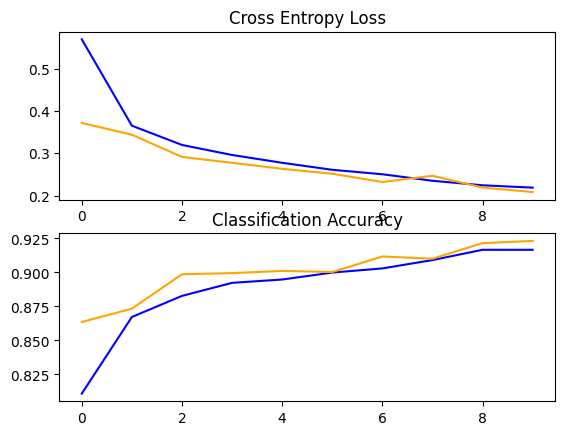

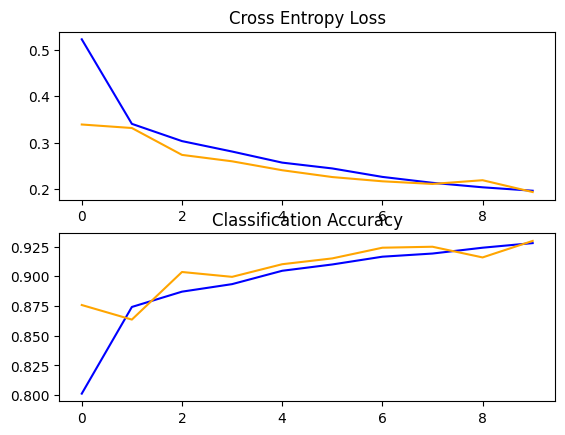

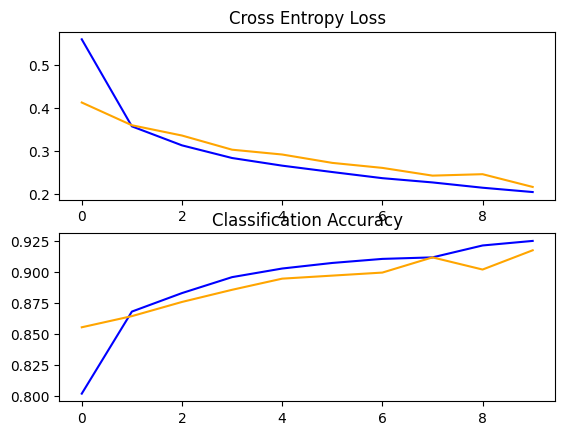

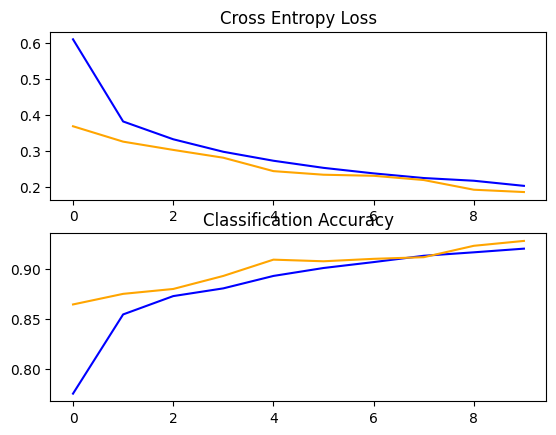

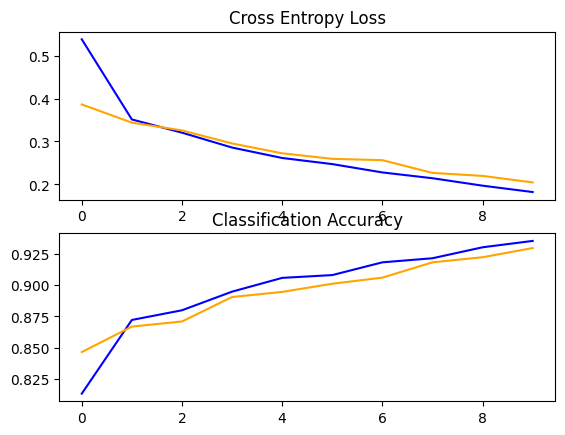

In [78]:
summarize_diagnostics(histories)

In [67]:
model=define_model()
model.fit(train_setX, train_setY, epochs=10, batch_size=16, verbose=0)
model.save('final_model5.keras')


In [68]:
model = load_model('final_model4.keras')
_, acc = model.evaluate(test_setX,  test_setY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 92.418


In [69]:
#prediction=model.predict(samples_to_predict)
#print(prediction)